## Final Project Submission - Module 3

* **Student name:** Paulo Ramazza
* **Student pace:** self paced
* **Scheduled project review date/time:** 
* **Instructor name:** Eli Thomas

For this project, you'll be working with the Northwind database--a free, open-source dataset created by Microsoft containing data from a fictional company. You probably remember the Northwind database from our section on Advanced SQL.

The goal of this project is to test your ability to gather information from a real-world database and use your knowledge of statistical analysis and hypothesis testing to generate analytical insights that can be of value to the company. 

## Scope

**Objective:** The goal of this project is to query the database to get the data needed to perform a statistical analysis. In this statistical analysis, you'll need to perform a hypothesis test (or perhaps several) to answer the following question:

* **Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?**



# Questions

In addition to answering this question with a hypothesis test, you will also need to come up with at least 3 other hypotheses to test on your own. These can by anything that you think could be imporant information for the company.

- **Question 1**: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
- **Question 2**: Is there a statistically significant difference in performance between employees from US and UK?
- **Question 3**: Is there statistically significant difference in discounts given by USA and UK employees?
- **Question 4**: Is there a statistically significant difference in demand of produce each month?
- **Question 5**: Is there a statistically significant difference in discount between categories?
- **Question 6**: Is there a statistically significant difference in performance of shipping companies?

## Importing libraries

In [1]:
import sqlite3 # for database
import pandas as pd # for dataframe
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import numpy as np # analysis
from scipy import stats # significance levels, normality
import itertools # for combinations
import statsmodels.api as sm # anova
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings('ignore') # hide matplotlib warnings

## Connecting to database

In [2]:
# Connecting to database
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

In [3]:
# List of all tables
tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
tables = [i[0] for i in tables]

## Converting all tables into dataframes

In [4]:
# Loop to put all tables into pandas dataframes
dfs = []
for i in tables:
    table = c.execute('select * from "'+i+'"').fetchall()
    columns = c.execute('PRAGMA table_info("'+i+'")').fetchall()
    df = pd.DataFrame(table, columns=[i[1] for i in columns])
    # Cute little function to make a string into variable name
    foo = i+"_df"
    exec(foo + " = df") # => TableName_df
    # Keep all dataframe names in the list to remember what we have
    dfs.append(foo)

# Exploratory Data Analysis

## Order quantities by discount or not discount applied

First of all, let's compare make it more visual and check if discount affects the number of orders for a list of products

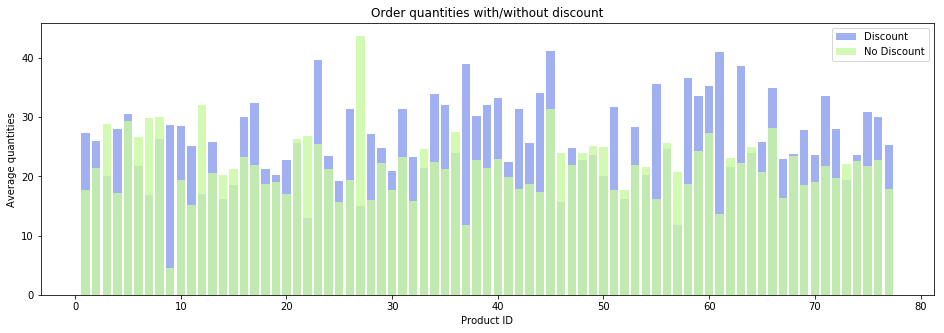

Conclusion
On average 70.0% of discounted products were sold in larger quantities
Average order quantity with discount - 26.43 items, without - 21.81 items


In [5]:
discount = OrderDetail_df[OrderDetail_df['Discount']!=0].groupby('ProductId')['Quantity'].mean()
no_discount = OrderDetail_df[OrderDetail_df['Discount']==0].groupby('ProductId')['Quantity'].mean()
plt.figure(figsize=(16,5))
plt.bar(discount.index, discount.values, alpha=1, label='Discount', color='#a0b0f0')
plt.bar(no_discount.index, no_discount.values, alpha=0.8, label='No Discount', color='#c9f9a0')
plt.legend()
plt.title('Order quantities with/without discount')
plt.xlabel('Product ID')
plt.ylabel('Average quantities')
plt.show()

print('Conclusion')
print("On average {}% of discounted products were sold in larger quantities".format(round(sum(discount.values > no_discount.values)/len(discount.values)*100),2))
print("Average order quantity with discount - {} items, without - {} items".format(round(discount.values.mean(),2), round(no_discount.values.mean(),2)))

There is evidence that customers tend to buy products on sale (with discount applied)

I will run an experiment, to confirm that our hypotheses is valid

## Orders grouped by discount level

First step, let's calculate discount levels...

In [6]:
# Let's get all discount levels
discounts = OrderDetail_df['Discount'].unique()
discounts.sort()
print('Discount levels')
print(discounts)

Discount levels
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.1  0.15 0.2  0.25]


In [7]:
# Group orders by discount amounts
# Each group is a DataFrame containing orders with certain discount level
groups = {}
for i in discounts:
    groups[i] = OrderDetail_df[OrderDetail_df['Discount']==i]

In [8]:
# Create new DataFrame with Discounts and Order quantities
discounts_df = pd.DataFrame(columns=['Discount %','Orders','Avg. Order Quantity'])
for i in groups.keys():
    discounts_df = discounts_df.append({'Discount %':i*100,'Orders':len(groups[i]),'Avg. Order Quantity':groups[i]['Quantity'].mean()}, ignore_index=True)

discounts_df

,Discount %,Orders,Avg. Order Quantity
0,0.0,1317.0,21.715262
1,1.0,1.0,2.000000
2,2.0,2.0,2.000000
3,3.0,3.0,1.666667
4,4.0,1.0,1.000000
5,5.0,185.0,28.010811
6,6.0,1.0,2.000000
7,10.0,173.0,25.236994
8,15.0,157.0,28.382166
9,20.0,161.0,27.024845


Even though the table above shows a tendency of the highest the discount the higuest number of orders, we could see a exception in this rule (5% discount). It indicates a seasonal sales.

Lets drop these discount levels from our experiment

## Bootstrap

Bootstrapping is a type of resampling where large number of smaller samples of the same size are repeatedly drawn, with replacement, from a single original sample.

In [9]:
def bootstrap(sample, n):
    bootstrap_sampling_dist = []
    for i in range(n):
        bootstrap_sampling_dist.append(np.random.choice(sample, size=len(sample), replace=True).mean())
    return np.array(bootstrap_sampling_dist)

## Cohen's d

Cohen's d is an effect size used to indicate the standardised difference between two means. It can be used, for example, to accompany reporting of t-test and ANOVA results. It is also widely used in meta-analysis. Cohen's d is an appropriate effect size for the comparison between two means.

In [10]:
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return abs(d)

## Visualization

In [1]:
def visualization(control, experimental):
    plt.figure(figsize=(10,6))
    sns.distplot(experimental, bins=50,  label='Experimental')
    sns.distplot(control, bins=50,  label='Control')

    plt.axvline(x=control.mean(), color='k', linestyle='--')
    plt.axvline(x=experimental.mean(), color='k', linestyle='--')

    plt.title('Control and Experimental Sampling Distributions', fontsize=14)
    plt.xlabel('Distributions')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Question #1

## Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

- $H_0$: there is no difference in order quantity due to discount
- $H_\alpha$: there is an increase in order quantity due to discount

Discounts potentially increases order quantity, so it would be acceptable to perform one-tailed test with $\alpha$ set to 0.025. If $p$ < $\alpha$, we reject null hypothesis.

## Welch's T-test

In statistics, Welch's t-test, or unequal variances t-test, is a two-sample location test which is used to test the hypothesis that two populations have equal means.

At first I created two distributions (control and experimental). Control distribution includes only order quantities without discount only, and experimental distribution includes order quantities with discount (at any level)

This experiment would answer a question if there is any difference in purchase quantity

Reject Null Hypothesis
Cohen's d: 0.2862724481729283


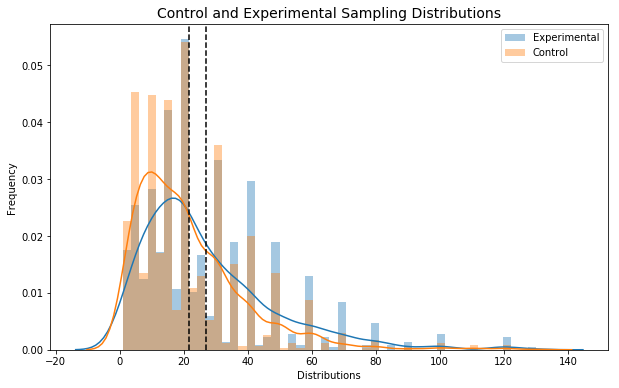

In [42]:
control = OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity']
experimental = OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity']

t_stat, p = stats.ttest_ind(control, experimental)
d = Cohen_d(experimental, control)

print('Reject Null Hypothesis') if p < 0.025 else print('Failed to reject Null Hypothesis')
print("Cohen's d:", d)
visualization(control, experimental)

Result of the experiment shows that there is a _**statistically significant**_ difference in orders quantities, hence we reject null hypothesis

The following step in the research would be to answer the question about at what discount level we see _**statisticaly significant**_ difference in orders quantities

We will follow the same process as previous experiment, but this time we'll break our experimental group into discount amounts

In [13]:
discounts_significance_df = pd.DataFrame(columns=['Discount %','Null Hypothesis','Cohens d'], index=None)

discounts = [0.05, 0.1, 0.15, 0.2, 0.25]
control = OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity']
for i in discounts:
    experimental = OrderDetail_df[OrderDetail_df['Discount']==i]['Quantity']
    st, p = stats.ttest_ind(control, experimental)
    d = Cohen_d(experimental, control)
    discounts_significance_df = discounts_significance_df.append( { 'Discount %' : str(i*100)+'%' , 'Null Hypothesis' : 'Reject' if p < 0.025 else 'Failed', 'Cohens d' : d } , ignore_index=True)    

discounts_significance_df

,Discount %,Null Hypothesis,Cohens d
0,5.0%,Reject,0.346877
1,10.0%,Reject,0.195942
2,15.0%,Reject,0.372404
3,20.0%,Reject,0.300712
4,25.0%,Reject,0.366593


Result of the test shows that there is _**statistically significant**_ difference in quantities between orders with no discount and applied discounts of 5%, 10%, 15%, 20%, 25%. Hence we reject null hypothesis

## Statistically significant difference between discount levels

- $H_0$: there is no difference in order quantity between discounts
- $H_\alpha$: there is a difference in order quantity between discounts

In [14]:
discounts = np.array([0.05, 0.1, 0.15, 0.2, 0.25])
comb = itertools.combinations(discounts, 2)
discount_levels_df = pd.DataFrame(columns=['Discount %','Null Hypothesis','Cohens d'], index=None)

for i in comb:
    
    control =      OrderDetail_df[OrderDetail_df['Discount']==i[0]]['Quantity']
    experimental = OrderDetail_df[OrderDetail_df['Discount']==i[1]]['Quantity']
    
    st, p = stats.ttest_ind(experimental, control)
    d = Cohen_d(experimental, control)
    
    discount_levels_df = discount_levels_df.append( { 'Discount %' : str(i[0]*100)+'% - '+str(i[1]*100)+'%', 'Null Hypothesis' : 'Reject' if p < 0.05 else 'Failed', 'Cohens d' : d } , ignore_index=True)    

discount_levels_df.sort_values('Cohens d', ascending=False)

,Discount %,Null Hypothesis,Cohens d
4,10.0% - 15.0%,Failed,0.149332
6,10.0% - 25.0%,Failed,0.145146
0,5.0% - 10.0%,Failed,0.127769
5,10.0% - 20.0%,Failed,0.089008
7,15.0% - 20.0%,Failed,0.068234
9,20.0% - 25.0%,Failed,0.062415
2,5.0% - 20.0%,Failed,0.047644
1,5.0% - 15.0%,Failed,0.017179
3,5.0% - 25.0%,Failed,0.010786
8,15.0% - 25.0%,Failed,0.006912


Result of the test shows that there is no _**statistically significant**_ difference in order quantity between discounts of 5%, 10%, 15%, 20% and 25%.

# Question 2
## Is there a statistically significant difference in performance between employees from US and UK?

- $H_0$: There is no difference in performance between US and UK employees
- $H_\alpha$: there is a difference in performance between US and UK employees

To find out the difference in performance we will perform two tests

In [15]:
employees_orders = pd.read_sql_query( '''
                                    
                                SELECT O.EmployeeId, E.Country, COUNT(O.Id) AS Total_Orders  
                                FROM [Order] AS O
                                JOIN Employee as E
                                ON O.EmployeeId = E.Id
                                GROUP BY O.EmployeeId
                                
                                ''' ,conn)

In [16]:
employees_orders

,EmployeeId,Country,Total_Orders
0,1,USA,123
1,2,USA,96
2,3,USA,127
3,4,USA,156
4,5,UK,42
5,6,UK,67
6,7,UK,72
7,8,USA,104
8,9,UK,43


Even though we can't see significance test, there is a fair difference in the amount of total orders two groups were able to process in two years.

## 2.1 Amount of orders processed by US and UK employees

In [17]:
# ANOVA Test
formula = 'Total_Orders ~ C(Country)'
lm = ols(formula, employees_orders).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq   df          F    PR(>F)
C(Country)  9446.755556  1.0  22.640129  0.002064
Residual    2920.800000  7.0        NaN       NaN


Result of ANOVA Test shows that there is _**statistically significant**_ difference in orders quantity between two groups of employees from USA and UK.

I want to investigate further into performance of employees and compare their order processing time, maybe thats the reason in such a big difference in amount of orders

## 2.2 Order Processing Time by US vs UK Employees

In this test, the aim is confirm if the processing time has any influence on the number of orders

In [18]:
usa_uk = pd.read_sql_query('''
                    
                    SELECT O.Id, O.OrderDate, O.ShippedDate, E.Country FROM [Order] AS O
                    JOIN Employee AS E
                    ON O.EmployeeId = E.Id

''',conn)

In [19]:
usa_uk.OrderDate = pd.to_datetime(usa_uk.OrderDate)
usa_uk.ShippedDate = pd.to_datetime(usa_uk.ShippedDate)
usa_uk['ProcessingTime'] = usa_uk.ShippedDate - usa_uk.OrderDate
usa_uk.ProcessingTime = usa_uk.ProcessingTime.dt.days

In [20]:
usa_uk.dropna(inplace=True)

In [21]:
usa = usa_uk[usa_uk.Country == 'USA']['ProcessingTime']
uk  = usa_uk[usa_uk.Country == 'UK']['ProcessingTime']

print(usa.mean(), uk.mean())
stats.ttest_ind(usa, uk)
print(Cohen_d(usa, uk))

8.375634517766498 8.807339449541285
0.06310985453186797


Result of the test shows that there is no _**statistically significant**_ difference in processing time, hence we  falied to reject null hypothesis

# Question 3
## Is there statistically significant difference in discounts given by USA and UK employees?

- $H_0$: There is no difference in discounts given by from USA and UK employees
- $H_\alpha$: There is a difference in discounts given by from USA and UK employees

### Read Database

In [22]:
usa_uk_discount = pd.read_sql_query('''

                    SELECT OD.Discount, E.Country FROM [Order] AS O
                    JOIN OrderDetail AS OD ON O.Id = OD.OrderId
                    JOIN Employee AS E ON O.EmployeeId = E.Id

''', conn)

In [23]:
formula = 'Discount ~ C(Country)'
lm = ols(formula, usa_uk_discount).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

               sum_sq      df         F    PR(>F)
C(Country)   0.067081     1.0  9.671415  0.001896
Residual    14.933259  2153.0       NaN       NaN


### Result

Result of the test shows that there is _**statistically significant**_ difference in discount amount between employees from USA and UK, hence we reject null hypothesis

Employees from USA tend to offer more discounts to their clients

# Question 4
## Is there a statistically significant difference in demand of produce each month?

- $H_0$: There is no difference in demand of produce each month
- $H_\alpha$: There is a difference in demand of produce each month

### Read Database

In [24]:
produce = pd.read_sql_query('''

                                SELECT O.OrderDate, OD.Quantity, OD.Discount, CategoryId FROM [Order] AS O
                                JOIN OrderDetail AS OD
                                ON O.Id = OD.OrderId
                                JOIN Product
                                ON Product.Id = OD.ProductId
                                WHERE Product.CategoryId = 7

''',conn)   

### Group data by month

In [25]:
produce.OrderDate = pd.to_datetime(produce.OrderDate)
produce['Month'] = produce.OrderDate.dt.month

In [26]:
produce.groupby('Month').mean()

,Quantity,Discount,CategoryId
Month,,,
1,16.545455,0.050000,7.0
2,15.555556,0.011111,7.0
3,21.500000,0.004545,7.0
4,29.105263,0.028947,7.0
5,12.888889,0.075556,7.0
6,21.285714,0.085714,7.0
7,26.375000,0.050000,7.0
8,15.666667,0.038889,7.0
9,17.500000,0.025000,7.0


### ANOVA Test

In [27]:
formula = 'Quantity ~ C(Month)'
lm = ols(formula, produce).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq     df         F    PR(>F)
C(Month)   4834.012843   11.0  1.318794  0.221691
Residual  41319.957745  124.0       NaN       NaN


### Result

There is no _**statistically significant**_ difference in order quantity between months, hence we failed to reject null hypothesis

# Question 5
## Is there a statistically significant difference in discount between categories?

- $H_0$: There is no difference in discount level between categories
- $H_\alpha$: There is a difference in discount level between categories

### Read Database

In [28]:
category_discount = pd.read_sql_query('''

                        SELECT OrderDetail.UnitPrice, Discount, CategoryId FROM OrderDetail
                        JOIN Product
                        ON OrderDetail.ProductId = Product.Id

''',conn)

### ANOVA Test

In [29]:
formula = 'Discount ~ C(CategoryId)'
lm = ols(formula, category_discount).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq      df         F    PR(>F)
C(CategoryId)   0.074918     7.0  1.539545  0.149326
Residual       14.925422  2147.0       NaN       NaN


### Result

Result of the test shows that there is no _**statistically significant**_ difference in discount level between categories, hence we failed to reject null hypothesis

# Question 6
## Is there a statistically significant difference in performance of shipping companies?

- $H_0$: There is no difference in discount level between categories
- $H_\alpha$: There is a difference in discount level between categories

In [30]:
Order_df.OrderDate = pd.to_datetime(Order_df.OrderDate)
Order_df.ShippedDate = pd.to_datetime(Order_df.ShippedDate)
Order_df.RequiredDate = pd.to_datetime(Order_df.RequiredDate)

Order_df['ProcessingTime'] = Order_df.ShippedDate - Order_df.OrderDate
Order_df['ShippingTime'] = Order_df.RequiredDate - Order_df.ShippedDate

Order_df.ShippingTime = Order_df.ShippingTime.dt.days
Order_df.ProcessingTime = Order_df.ProcessingTime.dt.days

In [31]:
Order_df.groupby('ShipVia').mean()

,Id,EmployeeId,Freight,ProcessingTime,ShippingTime
ShipVia,,,,,
1,10667.594378,4.232932,65.001325,8.571429,19.485714
2,10674.963190,4.536810,86.640644,9.234921,18.765079
3,10641.592157,4.400000,80.441216,7.473896,19.963855


In [32]:
formula = 'ProcessingTime ~ C(ShipVia)'
lm = ols(formula, Order_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq     df         F    PR(>F)
C(ShipVia)    433.501581    2.0  4.676819  0.009563
Residual    37354.696194  806.0       NaN       NaN


In [33]:
Shipper_df

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


### Result

Result of the test shows that there is a _**statistically significant**_ difference in performance of shipping companies, hence we reject null hypothesis

# Conclusion

 - There is huge difference in the number of order, based on its discounts "levels" (5%, 15%, 20% and 25%)
 - US staff have sold more products with lower discount level
 - Discounts were given across categories at the relatively same level

## Further Steps

- Reasons why employees from US had much more orders than from UK
- Find out optimal level of discount for products according to their price and possible seasonal demand